In [1]:
CATEGORY = '반려동물'  #분석할 카테고리
DIR = '/Users/soothingni/Downloads/NOUN_수정.txt'   #명사만 모은 최종 파일 경로
senti_list = ['분노', '불안', '행복', '희망']   #분류할 감정

In [2]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import operator
from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np

In [3]:
with open(DIR, 'r') as f:
    docs, IDs = zip(*[(x.split(',')[-1].strip(), x.split(',')[0]) for x in f.readlines() if x.split(',')[-1].strip() != 'Nouns' if x.split(',')[2] == CATEGORY])   #데이터 전체를 분석하고 싶다면(카테고리별이 아닌) 마지막 if 이하를 주석처리

#1. Word2Vec 실행
docs1 = [x.split(' ') for x in docs]

model = Word2Vec(docs1, window=3, min_count=3, size=100)

df = pd.read_csv(DIR)
df.rename(columns = {'Unnamed: 0': 'ID'}, inplace = True)

df_CATEGORY = df.iloc[list(IDs)]

#2. 분류에 참조할 감정 유의어 사전 생성
synonym_dict = {}
for KEYWORD in senti_list:
    #특정 단어와 문맥상 유사하게 사용된 단어
    top50 = model.wv.similar_by_word( KEYWORD ,topn=50)

    synonyms = [word for word, coef in top50 if coef >= 0.5]      #유의어 coef threshold를 0.5로 설정
    synonyms.append(KEYWORD)
    synonym_dict[KEYWORD] = synonyms
    
#3. 감정별 점수 딕셔너리 생성
senti_score = [0] * len(senti_list)
SENTI_DICT = dict(zip(senti_list, senti_score))
    
#4. 감정 분류 결과를 저장할 데이터프레임 생성
df_senti = pd.DataFrame(columns = ['ID', 'Vote_Count', '분노', '불안', '행복', '희망', '우세'])

#5. 함수 정의
def get_senti(word):
    global synonym_dict
    global SENTI_DICT
    for k, v in synonym_dict.items():
        if word in v:
            SENTI_DICT[k] += 1

def calc_percentage(dictionary):
    series  = pd.Series(dictionary)
    perc_series = series.apply(lambda x: x / series.sum())
    return perc_series

def concat_to_df(series):
    dom_senti = list(series.loc[series == series.max()].index)
    if len(dom_senti) == 1: dom_senti = series.idxmax()    #이 줄과 아랫줄 주석 처리하면 2개 이상의 감정이 동점인 데이터 보존함
    else: dom_senti = np.nan
    series2 = pd.Series({'ID': ID, 'Vote_Count':Vote_Count, '우세': dom_senti})
    total_series = pd.concat([series, series2])
    global df_senti
    df_senti = df_senti.append(total_series, ignore_index = True)

In [4]:
#6. 분류 실행
for k in range(len(df_CATEGORY)):
    SENTI_DICT = dict.fromkeys(SENTI_DICT, 0)   #SENTI_DICT 값 초기화
    ID = df_CATEGORY.ID.iloc[k]
    Vote_Count = df_CATEGORY.Vote_Count.iloc[k]

    for word in docs1[k]:
        get_senti(word)

    series = calc_percentage(SENTI_DICT)
    
    concat_to_df(series)

In [5]:
#7. 분류 결과 확인
df_senti.dropna(how = 'any', inplace = True)    #결측치 제거
df_senti

,ID,Vote_Count,분노,불안,행복,희망,우세
0,38,2,0.000000,0.000000,1.000000,0.000000,행복
3,237,0,0.333333,0.111111,0.555556,0.000000,행복
4,253,4,0.000000,0.000000,1.000000,0.000000,행복
6,393,0,0.000000,0.400000,0.600000,0.000000,행복
7,482,5,0.000000,0.000000,1.000000,0.000000,행복
...,...,...,...,...,...,...,...
4475,433396,815,0.050000,0.250000,0.650000,0.050000,행복
4476,433558,636,0.000000,0.176471,0.647059,0.176471,행복
4477,433577,10177,0.250000,0.000000,0.583333,0.166667,행복
4478,433578,4641,0.000000,0.000000,0.333333,0.666667,희망


In [6]:
#8. 감정별 빈도
freq_df = df_senti.groupby('우세').count().ID
freq_df

우세
분노     125
불안     214
행복    2213
희망     132
Name: ID, dtype: int64

/Users/soothingni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


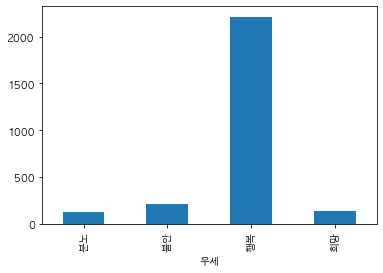

In [7]:
#9. 시각화
rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
freq_df.plot('bar')